# Quantum Phase Estimation vs. Hadamard Test

In [26]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import time
token = input('Enter IBM API token: ')

from qiskit_aer.noise import NoiseModel
service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='rpi-rensselaer/general/general',
    token=token
)
rpi = service.backend("ibm_rensselaer")
sim = AerSimulator()

use_real_hardware = True

C:\Users\paulb\AppData\Local\Temp\ipykernel_11780\3898526616.py:14: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud" and "local" will be the only valid channels. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


## Table of Contents

* [Introduction](#Introduction)
* [Hadamard Test Data Generation](#Hadamard-Test-Data-Generation)
* [Quantum Phase Estimation Data Generation](#QPEsim)
* [Comparison of HT and QPE](#Comparison)

## Introduction

This section entails a comparison between the HT and QPE algorithms. To ensure that the same value is estimated for both algorithms, a phase of $e^{i2\pi\varphi}$ is applied to both QPE and HT. To extract the value $\varphi$ using HT, the estimate is simply divided by $2\pi$. 
        
Consider the unitary matrix 
$$ U 
= \begin{bmatrix}
    1 & 0 \\
    0 & e^{i2\pi\varphi}
\end{bmatrix},$$
where $\varphi = 1/3$ and the goal is to estimate this value with precision $\epsilon$. 

For this comparison both algorithms are run for $20$ total trials spanning from $10^3$ to $10^5$ shots for HT and $1$ to $20$ ancillary qubits with $1000$ shots for QPE. Both approaches are run for all $20$ trials on both a fault-tolerant simulation and on the RPI IBM Quantum System One quantum computer. These parameters were chosen because they span the range of practical simulations with the given classical resources for quantum simulation.

To visualize the convergence in error with respect to each algorithm's quantum resources, their individual errors are plotted in a joint graph for both the simulation and quantum hardware. The run time of each algorithm is also estimated and plotted in a joint graph to observe how it scales for the respective algorithms per their allocated quantum resource.

In [27]:
varphi = 1/3 # Exact value of varphi to estimate for this example

varphi = varphi%(1)
angle  = varphi*2*pi
print("varphi:\t\t", varphi)
print("phase angle:\t", angle, "rad")

varphi:		 0.3333333333333333
phase angle:	 2.0943951023931953 rad


## Hadamard Test Data Generation

First, the Hadamard test is run on a fault-tolerant simulation as before, but with the unitary $U$ above, estimating $\varphi$.

In [28]:
def create_HT(theta, test, device):
    circuit = QuantumCircuit(2,1)
    circuit.x(1)
    circuit.h(0)
    if test == 'Im': circuit.sdg(0)
    circuit.cp(theta,0,1) 
    circuit.h(0) 
    circuit.measure(0,0)
    tcircuit = transpile(circuit, backend = device, optimization_level = 3)
    return tcircuit

With each test run for $1000$ shots, it is clear that the HT algorithms successfully estimate $\varphi$. We now cycle through $10^3 - 10^5$ shots appending the error and run time of each trial to a list to plot the error convergence and run time as the shots increase on the simulation.

In [29]:
# Calculate the simulated runtime and error
backend = sim
sampler = Sampler(backend)
trials = [int(shots) for shots in np.logspace(3, 5, 20)] # shots needs to be an integer
HT_sim_runtime = []
HT_sim_error = []
for num_shots in trials:
    total_time = 0
    transRe = create_HT(angle, 'Re', backend)
    start = time.time()
    resultRe = sampler.run([transRe], shots = num_shots).result()[0]
    end = time.time()
    total_time += end-start
    countsRe = resultRe.data.c.get_counts()

    transIm = create_HT(angle, 'Im', backend)
    start = time.time()
    resultIm = sampler.run([transIm], shots = num_shots).result()[0]
    end = time.time()
    total_time += end-start
    countsIm = resultIm.data.c.get_counts()

    HT_sim_runtime.append(total_time)
    
    re_p0 = im_p0 = 0
    if countsRe.get('0') is not None:
        re_p0 = countsRe['0']/num_shots
    if countsIm.get('0') is not None:
        im_p0 = countsIm['0']/num_shots

    # compute monte-carlo error
    HT_sim_error.append((re_p0*(1 - re_p0)/num_shots)**(0.5))

In [30]:
backend = rpi
if not use_real_hardware: backend = AerSimulator(noise_model=NoiseModel.from_backend(backend))
sampler = Sampler(backend)
trials = [int(shots) for shots in np.logspace(3, 5, 20)]
HT_hardware_runtimes = []
HT_hardware_error = []
for num_shots in trials:
    total_time = 0
    transRe = create_HT(angle, 'Re', backend)
    if not use_real_hardware: start = time.time()
    job = sampler.run([transRe], shots = num_shots)
    resultRe = job.result()[0]
    if not use_real_hardware:
        end = time.time()
        total_time += end-start
    else:
        total_time += job.metrics()['usage']['quantum_seconds']
    countsRe = resultRe.data.c.get_counts()

    transIm = create_HT(angle, 'Im', backend)
    if not use_real_hardware: start = time.time()
    job = sampler.run([transIm], shots = num_shots)
    resultRe = job.result()[0]
    if not use_real_hardware:
        end = time.time()
        total_time += end-start
    else:
        total_time += job.metrics()['usage']['quantum_seconds']
    countsIm = resultIm.data.c.get_counts()

    HT_hardware_runtimes.append(total_time)
    
    re_p0 = im_p0 = 0
    if countsRe.get('0') is not None:
        re_p0 = countsRe['0']/num_shots
    if countsIm.get('0') is not None:
        im_p0 = countsIm['0']/num_shots

    # compute monte-carlo error
    HT_hardware_error.append((re_p0*(1 - re_p0)/num_shots)**(0.5))
    print(f'Trial for {num_shots} shots is done')
print('All trials completed')

Trial for 1000 shots is done
Trial for 1274 shots is done
Trial for 1623 shots is done
Trial for 2069 shots is done
Trial for 2636 shots is done
Trial for 3359 shots is done
Trial for 4281 shots is done
Trial for 5455 shots is done
Trial for 6951 shots is done
Trial for 8858 shots is done
Trial for 11288 shots is done
Trial for 14384 shots is done
Trial for 18329 shots is done
Trial for 23357 shots is done
Trial for 29763 shots is done
Trial for 37926 shots is done
Trial for 48329 shots is done
Trial for 61584 shots is done
Trial for 78475 shots is done
Trial for 100000 shots is done
All trials completed


## Quantum Phase Estimation Simulation

Now the quantum phase estimation algorithm is run on the simulation for the unitary $U$ estimating $\varphi$.

In [31]:
def add_inv_fourier_transform(circuit, qubits, show_steps = False):
    circuit.barrier()
    for i in range(int(qubits/2)):
        circuit.swap(i, qubits-i-1)
    for highest in range(qubits):
        if show_steps: print("\nPreforming inverse transform on qubit", highest)
        circuit.barrier()
        for qubit in range(highest):
            # qubit = highest-j-1
            if show_steps: print("\tControl Phase -π/2^"+str(highest-qubit)+" gate applied to", highest, "using qubit", qubit, "as control")
            circuit.cp(-pi/2**(highest-qubit), highest, qubit)
        if show_steps: print("\tAdding H gate to qubit", highest)
        circuit.h(highest) 
    if show_steps: print("\nCompleted transformation\n")

def setup(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.h(i)

def measure(circuit, ancilla_bits):
    for i in range(ancilla_bits):
        circuit.measure(i,i)

def QPE(ancilla_bits, varphi, device):
    qc = QuantumCircuit(ancilla_bits+1, ancilla_bits)
    setup(qc, ancilla_bits)
    qc.x(ancilla_bits)
    qc.barrier()
    for i in range(ancilla_bits):
        qc.cp((2*pi*varphi)*2**(i), ancilla_bits,i)
    add_inv_fourier_transform(qc,ancilla_bits)
    measure(qc, ancilla_bits)
    tqc = transpile(qc, backend = device, optimization_level = 3)
    return tqc

With $3$ ancillary qubits run for $1000$ shots, it is clear that the QPE algorithm successfully estimates $\varphi$. We now cycle through $1 - 20$ ancillas appending the error and run time of each trial to a list to plot the error convergence and run time as the qubits increase on the simulation.

In [32]:
backend = sim
sampler = Sampler(backend)

anc_bits = np.arange(1,21,1)
QPE_sim_runtimes = []
QPE_sim_error = []
for bits in anc_bits:
    tqc = QPE(bits, varphi, backend)
    job = sampler.run([tqc], shots=1000)
    result = job.result()[0]
    start = time.time()
    counts = result.data.c.get_counts()
    end = time.time()
    QPE_sim_runtimes.append(end-start)

    binary_num = ''
    max_num = 0
    for key in counts:
        if (counts[key] > max_num):
            max_num = counts[key]
            binary_num = key
    decimal_num = 0
    for i in range(len(binary_num)):
        decimal_num += int(binary_num[i])/2**(i+1)
    QPE_sim_error.append(abs(angle - 2*pi*decimal_num))
    print(f'Trial for {bits} ancilla bits is done')
print('All trials completed')

Trial for 1 ancilla bits is done
Trial for 2 ancilla bits is done
Trial for 3 ancilla bits is done
Trial for 4 ancilla bits is done
Trial for 5 ancilla bits is done
Trial for 6 ancilla bits is done
Trial for 7 ancilla bits is done
Trial for 8 ancilla bits is done
Trial for 9 ancilla bits is done
Trial for 10 ancilla bits is done
Trial for 11 ancilla bits is done
Trial for 12 ancilla bits is done
Trial for 13 ancilla bits is done
Trial for 14 ancilla bits is done
Trial for 15 ancilla bits is done
Trial for 16 ancilla bits is done
Trial for 17 ancilla bits is done
Trial for 18 ancilla bits is done
Trial for 19 ancilla bits is done
Trial for 20 ancilla bits is done
All trials completed


In [38]:
backend = rpi
if not use_real_hardware: backend = AerSimulator(noise_model=NoiseModel.from_backend(backend))
sampler = Sampler(backend)

anc_bits = np.arange(1,21,1)
QPE_hardware_runtimes = []
QPE_hardware_error = []
for bits in anc_bits:
    tqc = QPE(bits, varphi, backend)
    job = sampler.run([tqc], shots=1000)
    result = job.result()[0]
    if not use_real_hardware: start = time.time()
    counts = result.data.c.get_counts()
    if not use_real_hardware:
        end = time.time()
        total_time = end-start
    else:
        total_time = job.metrics()['usage']['quantum_seconds']
    QPE_hardware_runtimes.append(total_time)
    
    binary_num = ''
    max_num = 0
    for key in counts:
        if (counts[key] > max_num):
            max_num = counts[key]
            binary_num = key
    decimal_num = 0
    for i in range(len(binary_num)):
        decimal_num += int(binary_num[i])/2**(i+1)
    QPE_hardware_error.append(abs(angle - 2*pi*decimal_num))
    print(f'Trial for {bits} ancilla bits is done')
print('All trials completed')

Trial for 1 ancilla bits is done
Trial for 2 ancilla bits is done
Trial for 3 ancilla bits is done
Trial for 4 ancilla bits is done
Trial for 5 ancilla bits is done
Trial for 6 ancilla bits is done
Trial for 7 ancilla bits is done
Trial for 8 ancilla bits is done
Trial for 9 ancilla bits is done
Trial for 10 ancilla bits is done
Trial for 11 ancilla bits is done
Trial for 12 ancilla bits is done
Trial for 13 ancilla bits is done
Trial for 14 ancilla bits is done
Trial for 15 ancilla bits is done
Trial for 16 ancilla bits is done
Trial for 17 ancilla bits is done
Trial for 18 ancilla bits is done
Trial for 19 ancilla bits is done
Trial for 20 ancilla bits is done
All trials completed


## Comparison

With the error convergence and run time for both algorithms, we can now compare the algorithms for the $20$ trials.

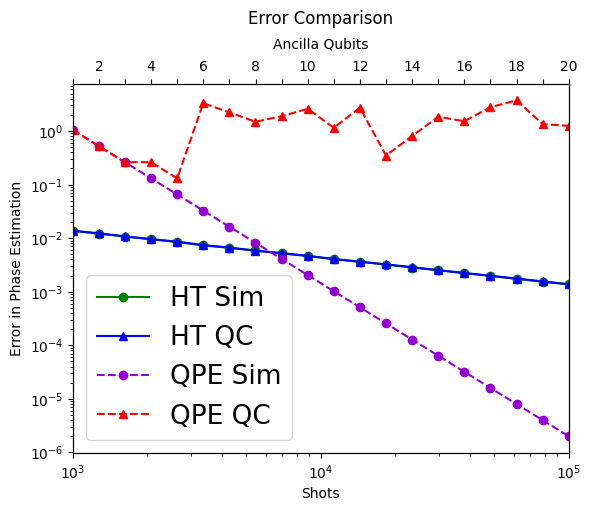

In [39]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

# Plot all data on the same axis
lin1, = ax.loglog(trials, HT_sim_error, 'go-', label='HT Sim')
lin2, = ax.loglog(trials, HT_hardware_error, 'b^-', label='HT QC')
lin3, = ax.loglog(trials, QPE_sim_error, 'darkviolet', marker='o', ls='--', label='QPE Sim')
lin4, = ax.loglog(trials, QPE_hardware_error, 'r^--', label='QPE QC')

ax.set_xlim(10**3,10**5)

# Ancilla x-axis
ax2.set_xlim(1,20)
ax2.set_xticks(anc_bits)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax2.set_xlabel('Ancilla Qubits', labelpad = 8)

# y log-scale
nticks = 9
maj_loc = ticker.LogLocator(numticks=nticks)
min_loc = ticker.LogLocator(subs='all', numticks=nticks)
ax2.yaxis.set_major_locator(maj_loc)
ax2.yaxis.set_minor_locator(min_loc)

ax.set_xlabel("Shots")
ax.set_ylabel("Error in Phase Estimation")
plt.title('Error Comparison', pad = 10)
ax.legend(loc='lower left', fontsize=19)

plt.show()

Looking at the error for each algorithm on the real quantum machine, the HT error is exactly the same as the theoretical output. However, the error for QPE is vastly different than theoretically predicted. For $t\leq3$ ancillary qubits, QPE follows the theory closely, but when $t>3$, the error does not decrease as predicted. With each increase in ancilla qubits, many new gates are introduced into the system creating too much noise for QPE to be effective. To mitigate this noise, Qiskit's built-in circuit optimization is used, where the argument $\texttt{optimization\_level}$ equal to $0, 1, 2,$ or $3$ is set at the transpilation level where a higher optimization level mitigates the most noise. Notably, using $\texttt{ optimization\_level=3}$, we observe the current hardware to be still too noisy to yield accurate results. 

In [40]:
anc_bit = np.arange(1,21,1)
depths = [[],[],[],[]]
for opt in range(4):
    for bit in anc_bit:
        qc = QPE(bit, angle, rpi)
        measure(qc, bit)
        qc_trans = transpile(qc, backend = rpi, optimization_level=opt)
        filter = lambda x: x.operation.name == "ecr" # create a filter for the 2 qubit gates
        twodepth = qc_trans.depth(filter)
        if opt == 0:           
            depths[0].append(twodepth)
        elif opt == 1:           
            depths[1].append(twodepth)
        elif opt == 2:           
            depths[2].append(twodepth)
        else:
            depths[3].append(twodepth)

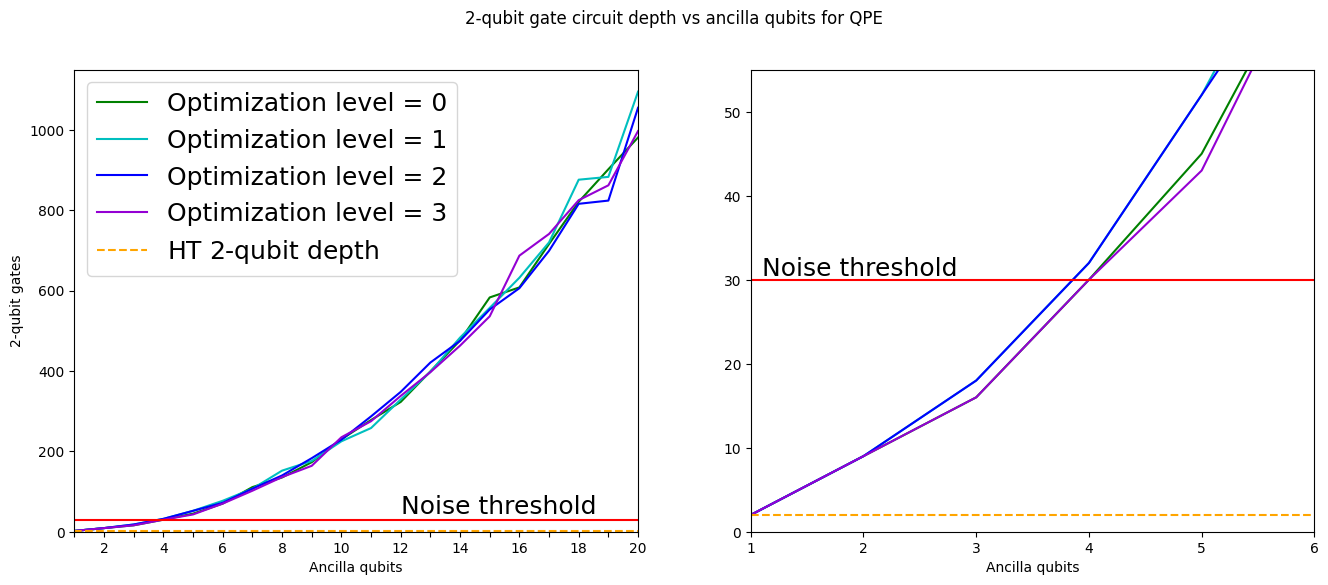

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
axes[0].plot(anc_bit, depths[0], 'g', ls = '-', label = 'Optimization level = 0')
axes[0].plot(anc_bit, depths[1], 'c', ls = '-', label = 'Optimization level = 1')
axes[0].plot(anc_bit, depths[2], 'b', ls = '-', label = 'Optimization level = 2')
axes[0].plot(anc_bit, depths[3], 'darkviolet', ls = '-', label = 'Optimization level = 3')
axes[0].set_xticks(anc_bit)

for label in axes[0].xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

val = str(depths[3][3])

axes[0].axhline(y=depths[3][3], color='r', linestyle='-')
axes[0].axhline(y=2, color='orange', linestyle='--', label = 'HT $2$-qubit depth')
axes[0].text(12, depths[3][3] + 15, "Noise threshold", fontsize = 18, color = 'k')
axes[0].set_ylim(0)
axes[0].set_xlim(1,20)

fig.suptitle('2-qubit gate circuit depth vs ancilla qubits for QPE')
axes[0].legend(loc='upper left', fontsize = 18)
axes[0].set_xlabel('Ancilla qubits')
axes[0].set_ylabel('2-qubit gates')

axes[1].set_xlabel('Ancilla qubits')

axes[1].plot(anc_bit, depths[0], 'g', ls = '-', label = 'Optimization level $= 0$')
axes[1].plot(anc_bit, depths[1], 'c', ls = '-', label = 'Optimization level $= 1$')
axes[1].plot(anc_bit, depths[2], 'b', ls = '-', label = 'Optimization level $= 2$')
axes[1].plot(anc_bit, depths[3], 'darkviolet', ls = '-', label = 'Optimization level $= 3$')
axes[1].set_xticks(anc_bit)

axes[1].axhline(y=depths[3][3], color='r', linestyle='-')
axes[1].axhline(y=2, color='orange', linestyle='--', label = 'HT depth')
axes[1].text(1.1, depths[3][3] + 0.5, "Noise threshold", fontsize = 18, color = 'k')
axes[1].set_ylim(0,55)
axes[1].set_xlim(1,6)

plt.show()
fig.tight_layout()

A common resource for analyzing the noise is the circuit depth. This integer number represents the number of gates that the circuit executes. The gates that are particularly affected by noise are the $2$-qubit gates. The plot above shows the number of $2$-qubit gates for QPE as a function of the ancillary qubits for different optimization levels. We observe that optimization levels $2$ and $3$ are more effective than levels $0$ or $1$ in reducing the number of 2-qubit gates. However, even with $\texttt{ optimization\_level=3}$, QPE with more than four ancillary qubits yields circuits that are too deep to be simulated on real quantum machines.

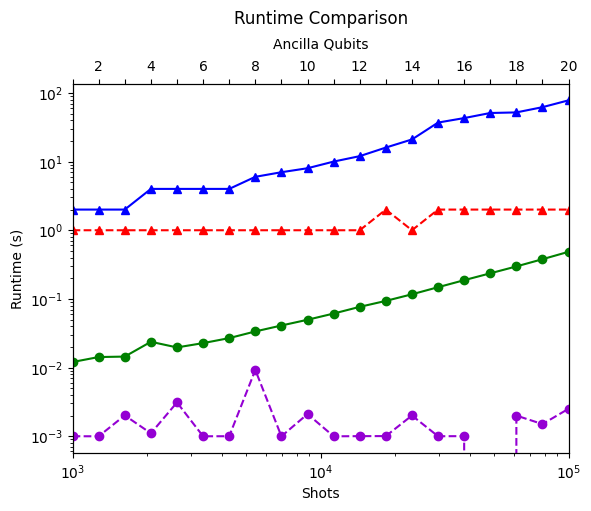

In [42]:
fig, ax = plt.subplots()
ax2 = ax.twiny()

# Plot all data on the same axis
lin1, = ax.loglog(trials,QPE_sim_runtimes, color = 'darkviolet', marker ='o', ls = '--', label = 'QPE Sim Runtime')
lin2, = ax.loglog(trials,QPE_hardware_runtimes,'r^', ls = '--', label = 'QPE QC Runtime')
lin3, = ax.loglog(trials,HT_sim_runtime, 'go', ls = '-', label = 'HT Sim Runtime')
lin4, = ax.loglog(trials,HT_hardware_runtimes, 'b^', ls = '-', label = 'HT QC Runtime')

ax.set_xlim(10**3,10**5)

# Ancilla x-axis
ax2.set_xlim(1,20)
ax2.set_xticks(anc_bits)
for label in ax2.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)

ax2.set_xlabel('Ancilla Qubits', labelpad = 8)

ax.set_xlabel("Shots")
ax.set_ylabel("Runtime (s)")
plt.title('Runtime Comparison', pad = 10)

plt.show()

The plot above shows a runtime comparison of HT and QPE on classical and quantum machines. For HT, it is evident that the simulated experiment requires less runtime per shot compared to its quantum counterpart. Since the total runtime of HT scales directly with the runtime per shot, we observe that the runtime of HT on the quantum computer exhibits an offset, resulting in a consistently higher runtime compared to the classical machine. For QPE, the classical simulation runtime is lower than the runtime on the quantum computer, but increases exponentially. On the quantum computer however, the runtime remains close to linear. For the tested system, we observe a likely crossing of the respective runtimes at some close trial out of our range. 

At $1$ ancilla qubit for QPE and $10^3$ shots for HT, the circuits should be identical. So why is the HT runtime greater than that of QPE? While the real HT circuit is exactly the same as the QPE circuit, there is the addition of the imaginary HT circuit to correctly obtain the phase angle probabilistically, and thus HT takes about twice as long per shot as QPE for $1$ ancilla qubit.

On the simulation, to increase the precision of the estimated phase, the runtime of both the HT and QPE will also increase. However, on the quantum computer, regardless of the value of $t$, QPE's runtime remains nearly linear, while the HT's runtime exponentially increases with the number of shots. 